## Further questions

__Exercises:__ <br>
E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

I will also improve the readability of the code so that running these different settings becomes easier. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# define stoi 
stoi = {}
allletters = sorted(set("".join(words)))

stoi = {s:i+1 for i,s in enumerate(allletters)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [4]:
def build_dataset(words1):
    X1 , Y1 = [], []
    block_size= 3 # can be reset to whatever you like

    for w in words1:
        context = [0]*block_size # contains indcies of context letters
        for ch in w + '.':
            ix = stoi[ch]
            Y1.append(ix) 
            X1.append(context)
            context = context[1:] + [ix] # update context and append new index

    X1 = torch.tensor(X1)
    Y1 = torch.tensor(Y1)
    print(X1.shape, Y1.shape)
    return X1,Y1

In [5]:
import random 
random.seed(378987987)

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xt, Yt = build_dataset(words[n2:])

torch.Size([182560, 3]) torch.Size([182560])
torch.Size([22820, 3]) torch.Size([22820])
torch.Size([22766, 3]) torch.Size([22766])


fixing the context window at 3 for now and calculating other hyperparams around it. 

In [85]:
# initialize network 

def init_network(g, hidden_neurons:int, embed_size:int):
    C = torch.randn((27,embed_size), generator=g)
    # hidden layer - 100 neurons
    W1 = torch.randn((3*embed_size,hidden_neurons), generator=g)
    b1 = torch.randn((hidden_neurons,), generator=g)
    # Output layer
    W2 = torch.randn((hidden_neurons,27), generator=g )
    b2 = torch.randn((27,), generator=g)

    return (C, W1, b1, W2, b2)

In [86]:
# To the function more precise, can include W,b as arguments as well
def loss_on_set(X, Y, C_emb, W1, b1, W2, b2):
    emb_fullset = C_emb[X] # 228146,3,2
    H = torch.tanh(emb_fullset.view(-1, C_emb.shape[1]*3) @ W1 + b1) # 228146,6 @ 6,100 => 228146, 100
    logits_fullset = H @ W2 + b2
    loss_on_set = F.cross_entropy(logits_fullset, target=Y)
    return loss_on_set

In [133]:
# initialize parameters: 
g = torch.Generator().manual_seed(378987987)

parameters = init_network(g, 300, 15)

for p in parameters:
    p.requires_grad = True

C, W1, b1, W2, b2 = parameters # global variables 

In [132]:
params = 0
for k in parameters:
    params+= k.nelement()

params

22332

In [134]:
for p in parameters:
    print(p.shape)

torch.Size([27, 15])
torch.Size([45, 300])
torch.Size([300])
torch.Size([300, 27])
torch.Size([27])


In [135]:
lossi = []
step = []

In [90]:
# training process: 
# function - arguments : iters, batch size, learning rate
# returns loss 

def train (iters, batch_size, alpha):
    """"
    arguments : iters, batch size, learning rate
    returns loss

    Call this function everytime you wish to train your neural net!
    """
    for iter in range(iters): 
        # 1000 mini batches of size 32 each 
        ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # assuming each batch has 32 data points 
        # Forward pass: 
        emb = C[Xtr[ix]]
        H = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # H dimension = (batch_size,neurons)
        logits = H @ W2 + b2
        loss = F.cross_entropy(logits, target=Ytr[ix])
        # Back pass
        for p in parameters:
            p.grad = None
        loss.backward()
        # update
        lr = alpha
        with torch.no_grad():
            for p in parameters:
                p.data -= lr * p.grad 

        # track stats
        step.append(iter)
        lossi.append(loss.item())


In [166]:
train(iters = 10000,batch_size = 32, alpha = 0.0005 )

In [167]:
print(lossi[-10:]) # loss on batch logged. 

[2.3849730491638184, 1.674147605895996, 2.1203906536102295, 1.987803339958191, 1.8095425367355347, 2.208472967147827, 2.020758628845215, 2.1947240829467773, 2.0611073970794678, 2.2313647270202637]


In [168]:
print(loss_on_set(Xtr, Ytr, C, W1, b1, W2, b2))
print(loss_on_set(Xdev, Ydev, C, W1, b1, W2, b2))

tensor(2.0465, grad_fn=<NllLossBackward0>)
tensor(2.1467, grad_fn=<NllLossBackward0>)


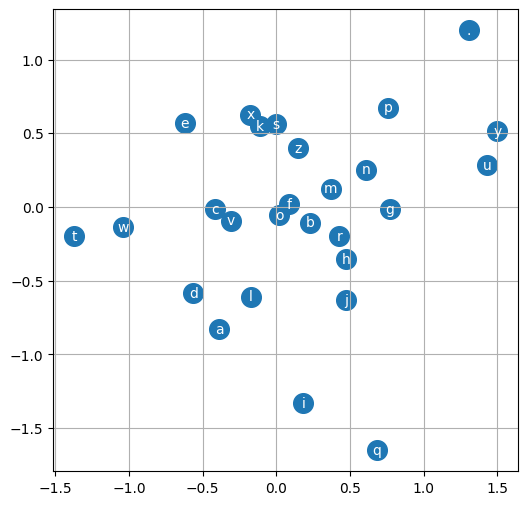

In [171]:
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

OK now the code look much more generalizable and tractable! 

Result logging: 

| Hidden layer size | embedding dim | training strategy | loss on dev set|
| :---------------- | :------: | ----: |----: |
| 200        |   5   | lr 0.1 for 50k, then 0.05, 0.01, 0.001 | 2.2148 |
| 200        |   10   | lr 0.1 for 50k, then 0.05, 0.01, 0.001 |2.1513 |
| 250    |  10   | lr 0.1 for 60k, then 0.05, 0.01, 0.001 |2.1606 |
| 300 |  15   | lr 0.1 for 70k, then 0.05, 0.01, 0.001 |2.1467 |


So the best dev loss has stagnated at 2.146, despite reducing the lr even more for fewer iterations. So I think it is a good time to test loss on test set now!



In [169]:
print(loss_on_set(Xt, Yt, C, W1, b1, W2, b2))

tensor(2.1360, grad_fn=<NllLossBackward0>)


And it seems to generalize well too! Since the test loss is close to the dev loss. 